In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 9

import pandas as pd

In [2]:
stim_ints = pd.read_csv('csvs/stimulus_intervals.csv', index_col=False)
stim_ints['interval'] = stim_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(')')), 
                                                            closed='left'))

cam_ints = pd.read_csv('csvs/camera_intervals.csv', index_col=False)
cam_ints['interval'] = cam_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(']')), 
                                                            closed='both'))

In [3]:
bombus_df = pd.read_csv('csvs/clean_dfs/bombus_df_manualedit.csv')
bombus_df['datetime'] = pd.to_datetime(bombus_df['datetime'])
bombus_df['color'] = None
for _, row in stim_ints.iterrows():
    mask = (bombus_df['pi'] == row['pi']) & (bombus_df['datetime'].between(row['interval'].left, row['interval'].right, inclusive='left'))
    bombus_df.loc[mask, 'color'] = row['color']
bombus_df = bombus_df.drop(columns=['filename', 'date', 'time_diff'])
bombus_df = bombus_df[['pi', 'datetime', 'color', 'species', 'sex']]

In [4]:
long_visits = pd.read_csv('stationary_bombus_filelist.txt', header=None, names=['filename'])
long_visits[['pi', 'datetime']] = long_visits['filename'].str.extract(r'^pi(\d+)_(\d{8}_\d{6})')
long_visits['pi'] = long_visits['pi'].astype(int)
long_visits = long_visits.drop(columns='filename')
long_visits['datetime'] = pd.to_datetime(long_visits['datetime'], format='%Y%m%d_%H%M%S')
long_visits = long_visits.sort_values(by=['pi', 'datetime'], ascending=[True, True]).reset_index(drop=True)

In [5]:
combined_df = pd.concat([bombus_df, long_visits], ignore_index=True)
combined_df = combined_df.sort_values(by=['pi', 'datetime'])
columns_to_fill = ['species', 'sex', 'color']
combined_df[columns_to_fill] = combined_df[columns_to_fill].ffill()
combined_df['time_diff'] = combined_df.groupby(['pi', 'color', 'species', 'sex'])['datetime'].diff()
combined_df['new_visit'] = (combined_df['time_diff'] > pd.Timedelta(seconds=4)) | (combined_df['time_diff'].isna())
combined_df['visit_id'] = combined_df.groupby(['species'])['new_visit'].cumsum()



In [6]:
# bombus_df['new_visit'] = (bombus_df['time_diff'] > 4) | (bombus_df['time_diff'].isna())
# bombus_df['visit_id'] = bombus_df.groupby(['species'])['new_visit'].cumsum()

In [7]:
# long_visits = pd.read_csv('stationary_bombus_filelist.txt', header=None, names=['filename'])
# long_visits[['pi', 'datetime']] = long_visits['filename'].str.extract(r'^pi(\d+)_(\d{8}_\d{6})')
# long_visits['pi'] = long_visits['pi'].astype(int)
# long_visits['datetime'] = pd.to_datetime(long_visits['datetime'], format='%Y%m%d_%H%M%S')
# # file_df = file_df.rename(columns={0: 'filename'})
# long_visits = long_visits.sort_values(by=['pi', 'datetime'], ascending=[True, True]).reset_index(drop=True)
# long_visits['date'] = pd.to_datetime(long_visits['datetime'].dt.date)
# long_visits['time_diff'] = long_visits.groupby(['pi', 'date'])['datetime'].diff().dt.total_seconds()
# long_visits['time_diff'].fillna(1, inplace=True)

In [8]:
visit_durations = (
    combined_df.groupby(['species', 'visit_id', 'pi', 'color'])['datetime']
    .agg(visit_start='min', visit_end='max')
    .reset_index())
visit_durations['duration'] = ((visit_durations['visit_end'] - visit_durations['visit_start']).dt.total_seconds())
visit_durations['pi_color'] = visit_durations['pi'].astype(str) + '_' + visit_durations['color']
visit_durations = visit_durations.sort_values(by='visit_start').reset_index(drop=True)
visit_durations = visit_durations.drop(index=[184, 187])

In [9]:
# MANUALLY ADD MULT VISITS

def add_rows(df, new_rows):
    new_df = pd.DataFrame(new_rows)
    new_df['visit_start'] = pd.to_datetime(new_df['visit_start'])
    new_df['visit_end'] = pd.to_datetime(new_df['visit_end'])
    new_df['duration'] = (new_df['visit_end'] - new_df['visit_start']).dt.total_seconds()
    for pi_color in new_df['pi_color'].unique():
        if pd.notna(pi_color):
            max_existing_id = df[df['pi_color'] == pi_color]['visit_id'].max()
            max_existing_id = max_existing_id if pd.notna(max_existing_id) else 0
            new_df.loc[new_df['pi_color'] == pi_color, 'visit_id'] = range(
                int(max_existing_id) + 1, int(max_existing_id) + 1 + len(new_df[new_df['pi_color'] == pi_color])
            )

    df = pd.concat([df, new_df], ignore_index=True)
    
    return df

new_rows = [
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 09:41:43', 'visit_end': '2024-07-23 10:02:38',
        'pi_color': '9_grn'
    },
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 10:02:19', 'visit_end': '2024-07-23 10:07:09',
        'pi_color': '9_grn'
    },
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 10:02:35', 'visit_end': '2024-07-23 10:05:19',
        'pi_color': '9_grn'
    }
]

visit_durations = add_rows(visit_durations, new_rows)

In [10]:
cumulative_visits = visit_durations.groupby(['pi_color', 'visit_start']).size().groupby(level=0).cumsum().reset_index(name='cumulative_count')

visit_duration_distribution = visit_durations['duration']

In [11]:
visit_durations[visit_durations['pi_color']=='9_grn']

,species,visit_id,pi,color,visit_start,visit_end,duration,pi_color
0,fervidus,67.0,9,grn,2024-07-11 07:28:42,2024-07-11 07:28:42,0.0,9_grn
33,unk,22.0,9,grn,2024-07-12 10:02:29,2024-07-12 10:02:29,0.0,9_grn
40,vosnesenskii,120.0,9,grn,2024-07-12 12:54:28,2024-07-12 12:54:28,0.0,9_grn
42,vosnesenskii,121.0,9,grn,2024-07-12 13:42:48,2024-07-12 13:42:48,0.0,9_grn
53,fervidus,68.0,9,grn,2024-07-13 09:24:11,2024-07-13 09:24:11,0.0,9_grn
55,vosnesenskii,122.0,9,grn,2024-07-13 09:39:15,2024-07-13 09:39:15,0.0,9_grn
63,fervidus,69.0,9,grn,2024-07-13 12:21:36,2024-07-13 12:21:36,0.0,9_grn
76,vosnesenskii,123.0,9,grn,2024-07-14 09:18:49,2024-07-14 09:18:49,0.0,9_grn
78,vosnesenskii,124.0,9,grn,2024-07-14 09:30:13,2024-07-14 09:30:13,0.0,9_grn
83,vosnesenskii,125.0,9,grn,2024-07-14 10:12:27,2024-07-14 10:12:27,0.0,9_grn


In [12]:
# bombus_df = pd.read_csv('csvs/clean_dfs/bombus_df_manualedit.csv')
# bombus_df['datetime'] = pd.to_datetime(bombus_df['datetime'])
# bombus_df = pd.merge(bombus_df, treatment_times[['pi', 'datetime', 'color']], on=['pi', 'datetime'], how='left')

# bombus_df

# bombus_visits = bombus_df[(bombus_df['time_diff'] > 4) | (bombus_df['time_diff'].isna())]

In [13]:
# combined_df['time_diff'] = combined_df.groupby(['pi', 'date'])['datetime'].diff().dt.total_seconds()
# bombus_df['time_diff'] = bombus_df.groupby(['pi', 'date'])['datetime'].diff().dt.total_seconds()

In [14]:
# bombus_df = combined_df.copy()

In [15]:
# bombus_df['new_visit'] = (bombus_df['time_diff'] > 4) | (bombus_df['time_diff'].isna())
# bombus_df['visit_id'] = bombus_df.groupby(['species'])['new_visit'].cumsum()

# visit_durations = (
#     bombus_df.groupby(['species', 'visit_id', 'pi', 'color'])['datetime']
#     .agg(visit_start='min', visit_end='max')
#     .reset_index()
# )
# visit_durations['duration'] = (
#     (visit_durations['visit_end'] - visit_durations['visit_start']).dt.total_seconds()
# )

# visit_duration_distribution = visit_durations['duration']

In [16]:
# periods = [('2024-07-11', '2024-07-18'),
#            ('2024-07-18', '2024-07-23'), 
#            ('2024-07-23', '2024-08-15'), 
#            ('2024-08-15', '2024-09-03'),
#            ('2024-09-03', '2024-09-10'), 
#            ]

periods = [('2024-07-11', '2024-07-17'),
           ('2024-07-18', '2024-07-24'), 
           ('2024-07-24', '2024-07-30')
           ]
periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in periods]


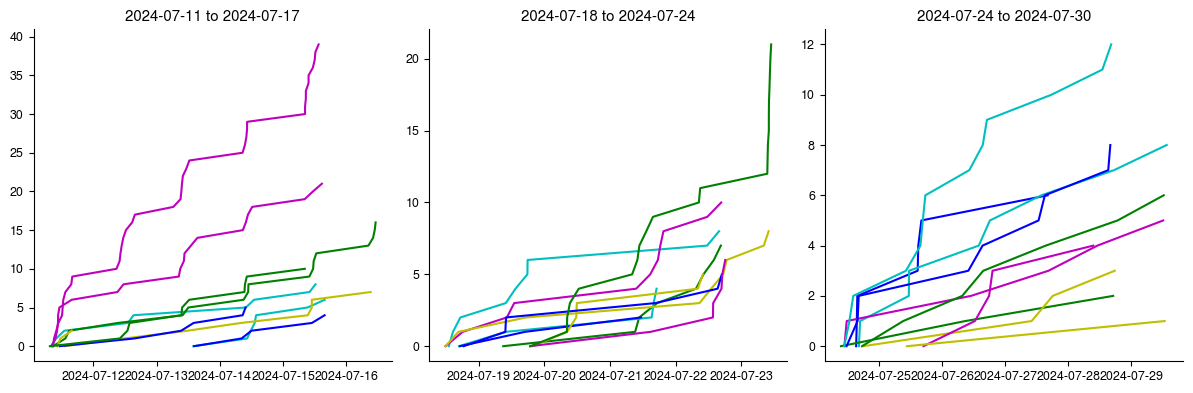

In [17]:
color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y'
}

fig, axes = plt.subplots(1, len(periods), figsize=(4 * len(periods), 4))

for i, (start, end) in enumerate(periods):
    period_subset = cumulative_visits[
        (cumulative_visits['visit_start'] >= start) & (cumulative_visits['visit_start'] <= end)
    ].copy()
    
    period_subset['adjusted_cumulative_count'] = (
        period_subset.groupby('pi_color')['cumulative_count']
        .transform(lambda x: x - x.min())
    )

    ax = axes[i] if len(periods) > 1 else axes 
    for key, group in period_subset.groupby('pi_color'):
        color_key = key.split('_')[-1]
        line_color = color_map.get(color_key, 'k')
        ax.plot(group['visit_start'], group['adjusted_cumulative_count'], label=key, color=line_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{start.date()} to {end.date()}')

plt.tight_layout()

In [18]:
# color_map = {
#     'cnt': 'm',
#     'blu': 'b',
#     'blv': 'c',
#     'grn': 'g',
#     'yel': 'y'
# }

# fig, axes = plt.subplots(1, len(periods), figsize=(4 * len(periods), 3))

# for i, (start, end) in enumerate(periods):
#     period_subset = cumulative_visits[
#         (cumulative_visits['visit_start'] >= start) & (cumulative_visits['visit_start'] <= end)
#     ].copy()
    
#     period_subset['adjusted_cumulative_count'] = (
#         period_subset.groupby('pi_color')['cumulative_count']
#         .transform(lambda x: x - x.min())
#     )

#     ax = axes[i]
#     for key, group in period_subset.groupby('pi_color'):
#         color_key = key.split('_')[-1]
#         pi_key = key.split('_')[0]
#         line_color = color_map.get(color_key, 'k')
#         ax.plot(group['visit_start'], group['adjusted_cumulative_count'], label=key, color=line_color)
#         ax.text(
#             group['visit_start'].iloc[-1]+ pd.Timedelta(seconds=3600),
#             group['adjusted_cumulative_count'].iloc[-1]+0.7,
#             f'{pi_key}',
#             color=line_color,
#             fontsize=9,
#             verticalalignment='center'
#         )
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_title(f'{start.date()} to {end.date()}')
#     ax.set_xticks(pd.date_range(start=start, end=end, freq='D'))
#     ax.set_xticklabels([(tick - start).days for tick in pd.date_range(start=start, end=end, freq='D')])


# plt.tight_layout()

In [19]:
# treatment_times['pi_color'] = treatment_times['pi'].astype(str) + '_' + treatment_times['color']
# treatment_times = treatment_times.sort_values('datetime')

In [20]:
# color_map = {
#     'cnt': 'm',
#     'blu': 'b',
#     'blv': 'c',
#     'grn': 'g',
#     'yel': 'y'
# }

# fig, axes = plt.subplots(1, len(periods), figsize=(4 * len(periods), 3))

# for i, (start, end) in enumerate(periods):
#     period_subset = treatment_times[
#         (treatment_times['datetime'] >= start) & (treatment_times['datetime'] <= end)
#     ].copy()


#     image_counts = (
#     period_subset.groupby(['pi_color', 'datetime'])
#     .size()
#     .groupby(level=0)
#     .cumsum()
#     .reset_index(name='cumulative_count')   
#     )

#     image_counts['adjusted_cumulative_count'] = (
#     image_counts.groupby('pi_color')['cumulative_count']
#     .transform(lambda x: x - x.min())
#     )

#     ax = axes[i]
#     for key, group in image_counts.groupby('pi_color'):
#         color_key = key.split('_')[-1]
#         pi_key = key.split('_')[0]
#         line_color = color_map.get(color_key, 'k')
#         ax.plot(group['datetime'], group['adjusted_cumulative_count'], label=key, color=line_color)
#         ax.text(
#             group['datetime'].iloc[-1]+ pd.Timedelta(seconds=3600),
#             group['adjusted_cumulative_count'].iloc[-1]+0.7,
#             f'{pi_key}',
#             color=line_color,
#             fontsize=9,
#             verticalalignment='center'
#         )

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_title(f'{start.date()} to {end.date()}')
#     ax.set_xticks(pd.date_range(start=start, end=end, freq='D'))
#     ax.set_xticklabels([(tick - start).days for tick in pd.date_range(start=start, end=end, freq='D')])


# plt.tight_layout()

In [21]:
# color_map = {
#     'cnt': 'm',
#     'blu': 'b',
#     'blv': 'c',
#     'grn': 'g',
#     'yel': 'y'
# }

# fig, ax = plt.subplots(figsize=(60, 2))
# for i, row in cam_ints.iterrows():
#     start = row['interval'].left
#     end = row['interval'].right
#     color = color_map[row['color']]
#     pi = row['pi']
#     ax.plot([start, end], [pi, pi], color=color)

# ax.set_yticks(combined_df['pi'].unique())
# ax.set_yticklabels(combined_df['pi'].unique())
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

In [22]:

# fig, axes = plt.subplots(1, len(periods), figsize=(4 * len(periods), 2))

# for i, (start, end) in enumerate(periods):
#     period_subset = cam_ints[
#         cam_ints['interval'].apply(lambda x: start <= x.left and x.right <= end)
#     ]
#     ax = axes[i]
#     for _, row in period_subset.iterrows():
#         ax.plot([row['interval'].left, row['interval'].right], [row['pi'], row['pi']], color=color_map[row['color']])

#     ax.set_title(f'{start.date()} to {end.date()}')
#     ax.set_xticks(pd.date_range(start=start, end=end, freq='D'))
#     ax.set_xticklabels([(tick - start).days for tick in pd.date_range(start=start, end=end, freq='D')])
#     ax.set_yticks(combined_df['pi'].unique())
#     ax.set_yticklabels(combined_df['pi'].unique())

# plt.tight_layout()



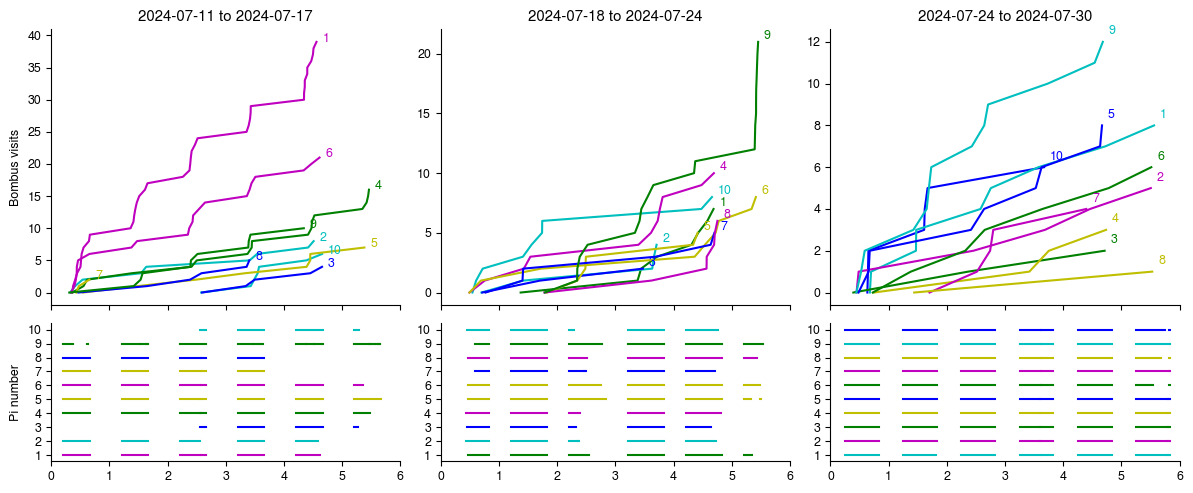

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

num_periods = len(periods)

for idx, (start, end) in enumerate(periods):
    ax = axes[0, idx]

    period_subset_visits = cumulative_visits[
        (cumulative_visits['visit_start'] >= start) & (cumulative_visits['visit_start'] <= end)
    ].copy()

    period_subset_visits['visit_start_days'] = (period_subset_visits['visit_start'] - start).dt.total_seconds() / (24 * 3600)

    period_subset_visits['adjusted_cumulative_count'] = (
        period_subset_visits.groupby('pi_color')['cumulative_count']
        .transform(lambda x: x - x.min())
    )

    for key, group in period_subset_visits.groupby('pi_color'):
        color_key = key.split('_')[-1]
        pi_key = key.split('_')[0]
        line_color = color_map.get(color_key, 'k')
        
        ax.plot(group['visit_start_days'], group['adjusted_cumulative_count'], label=key, color=line_color)
        
        ax.text(
            group['visit_start_days'].iloc[-1] + 0.1,  
            group['adjusted_cumulative_count'].iloc[-1] + 0.5,
            f'{pi_key}',
            color=line_color,
            fontsize=9,
            verticalalignment='center'
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{start.date()} to {end.date()}')
    ax.set_xticks(range(7))
    ax.set_xticklabels([])
    ax.set_xlim(0, 6)
    
    if idx == 0:
        ax.set_ylabel('Bombus visits')

for idx, (start, end) in enumerate(periods):
    ax = axes[1, idx]

    period_subset = cam_ints[
        cam_ints['interval'].apply(lambda x: start <= x.left and x.right <= end)
    ]

    for _, row in period_subset.iterrows():
        ax.plot([(row['interval'].left - start).total_seconds() / (24 * 3600), 
                 (row['interval'].right - start).total_seconds() / (24 * 3600)], 
                [row['pi'], row['pi']], color=color_map[row['color']])

    ax.set_xticks(range(7))
    ax.set_xticklabels(range(7))
    ax.set_yticks(combined_df['pi'].unique())
    ax.set_yticklabels(combined_df['pi'].unique())
    ax.set_xlim(0, 6)
    
    if idx == 0:
        ax.set_ylabel('Pi number')

plt.tight_layout()
plt.show()
